# Import and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../')

In [3]:
import os, sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
from get_loader import * 

/Users/ckh/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Function

# Data loader

In [40]:
dataset_folder = os.path.join("../datasets", "MSVD")
train_loader, train_dataset = get_loader(root_dir=dataset_folder, split="train", batch_size=1)
val_loader, val_dataset = get_loader(root_dir=dataset_folder, split="val", batch_size=1)
test_loader, test_dataset = get_loader(root_dir=dataset_folder, split="test", batch_size=1, num_workers=1)

In [42]:
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", batch_size=4)

for loader in [tiny_loader]:
    for idx, (features, captions) in enumerate(loader):
        print(idx, features.shape, captions.shape)

0 torch.Size([4, 17, 1128]) torch.Size([12, 4])
1 torch.Size([4, 44, 1128]) torch.Size([12, 4])
2 torch.Size([4, 21, 1128]) torch.Size([9, 4])
3 torch.Size([4, 17, 1128]) torch.Size([24, 4])
4 torch.Size([4, 13, 1128]) torch.Size([7, 4])
5 torch.Size([4, 44, 1128]) torch.Size([11, 4])
6 torch.Size([4, 11, 1128]) torch.Size([9, 4])
7 torch.Size([4, 17, 1128]) torch.Size([13, 4])
8 torch.Size([4, 44, 1128]) torch.Size([9, 4])
9 torch.Size([4, 21, 1128]) torch.Size([9, 4])
10 torch.Size([4, 24, 1128]) torch.Size([13, 4])
11 torch.Size([4, 11, 1128]) torch.Size([18, 4])
12 torch.Size([4, 17, 1128]) torch.Size([10, 4])
13 torch.Size([4, 24, 1128]) torch.Size([15, 4])
14 torch.Size([4, 24, 1128]) torch.Size([12, 4])
15 torch.Size([4, 19, 1128]) torch.Size([10, 4])
16 torch.Size([4, 12, 1128]) torch.Size([9, 4])
17 torch.Size([4, 44, 1128]) torch.Size([10, 4])
18 torch.Size([4, 19, 1128]) torch.Size([7, 4])
19 torch.Size([4, 44, 1128]) torch.Size([11, 4])
20 torch.Size([4, 11, 1128]) torch.Si

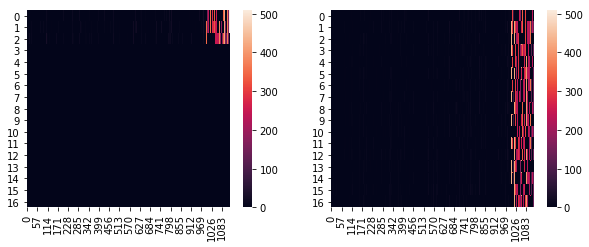

In [51]:
for i in range(features.shape[0]):
    plt.subplot(2,2,i+1)
    sns.heatmap(features[i])

In [61]:
img_feat = features[:,:,:1000]
img_feat.min(), img_feat.max()

(tensor(0.), tensor(48.1306))

In [62]:
audio_feat = features[:,:,1000:]
audio_feat.min(), audio_feat.max()

(tensor(0.), tensor(510.))

# Vocab set

In [ ]:
## pre-build vocab
dataset_folder = os.path.join("../datasets", "MSVD")
train_captions_file = os.path.join(dataset_folder, "metadata", "train.csv")
val_captions_file = os.path.join(dataset_folder, "metadata", "val.csv")
train_captions = pd.read_csv(train_captions_file)["Description"].tolist()
val_captions = pd.read_csv(val_captions_file)["Description"].tolist()
vocab_path = os.path.join(dataset_folder, "metadata", "vocab.pkl")

Vocabulary.prebuild(train_captions + val_captions, vocab_path)

In [ ]:
vocab = Vocabulary.load(vocab_path)
len(vocab)

# Training loop - DEV

In [5]:
import argparse
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from tqdm import tqdm

from get_loader import Vocabulary, get_loader
from losses import (EntropyLoss, GlobalReconstructionLoss,
                    LocalReconstructionLoss, TotalReconstructionLoss)

In [91]:
from models.features_captioning import FeaturesCaptioning
from models.captioning import AVCaptioning
from trainer import Trainer

In [92]:
dataset_folder = os.path.join("../datasets", "MSVD")
vocab_pkl = os.path.join(dataset_folder, "metadata", "vocab.pkl")
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", vocab_pkl=vocab_pkl)

Loading Vocab: ../datasets/MSVD/metadata/vocab.pkl 


In [93]:
vocab = Vocabulary.load(vocab_pkl)
print(len(vocab))

3201


In [70]:
decoder_config = {    
    'rnn_type'       : 'LSTM', # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_bidirectional': False,  # Bool
    'rnn_hidden_size': 512,
    'rnn_dropout'    : 0.5,    
    
    'in_feature_size': 1000+128,
    'embedding_size' : 128,
    'attn_size'      : 128,
    'output_size'    : 3201, #Vocab Size

    'rnn_teacher_forcing_ratio' : 1.0,
    'max_caption_len' : 30,
}

In [71]:
constructor_config = {   
    'type'           : 'local',  # ['global', 'local']
    'rnn_type'       : 'LSTM',    # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_bidirectional': False,     # Bool
    'hidden_size'    : 512,       # feature_size
    'rnn_dropout'    : 0.5,    
    'decoder_size'   : 128,       # decoder_hidden_size
    'attn_size'      : 128,       # only applied for local
}

In [88]:
from models.features_captioning import FeaturesCaptioning
from models.reconstructor import GlobalReconstructor, LocalReconstructor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = decoder_config.copy()
config['output_size'] = len(vocab)
model = FeaturesCaptioning(**config)
model.to(device)

rec_config = constructor_config.copy()
rec_config['decoder_size'] = config['rnn_hidden_size']
rec_config['hidden_size'] = config['in_feature_size']
# reconstructor = GlobalReconstructor(**rec_config,device=device)
reconstructor = LocalReconstructor(**rec_config,device=device)
reconstructor = reconstructor.to(device)

print("Start training")
tr = Trainer(checkpoint_name=os.path.join("checkpoints", "test.ckpt"))
tr.fit(
    model,
    reconstructor,
    tiny_loader,
    tiny_loader,
    device,
    epochs=1,
)


TRAIN:   0%|          | 0/4 [00:00<?, ?it/s]

Start training

Epoch 1/1:


TEST : 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, total=7.87, ce=7.87, e=2.58e+3, recon=1.89e+3]


Validation loss improved from 1000000.0 to 7.840059161186218.
Saving checkpoint to: checkpoints/test.ckpt


{'train_loss': [{'total': 8.017806887626648,
   'ce': 8.017806887626648,
   'e': 4101.0902099609375,
   'recon': 1813.4128112792969}],
 'val_loss': [{'total': 7.840059161186218,
   'ce': 7.840059161186218,
   'e': 4229.341003417969,
   'recon': 1956.0495910644531}],
 'test_loss': []}

In [73]:
data = iter(tiny_loader).next()
x,y = data
x.shape, y.shape

(torch.Size([32, 44, 1128]), torch.Size([15, 32]))

In [74]:
outputs, hidden = model.decode(x,y,max_caption_len=y.shape[0])
outputs.shape, hidden.shape

(torch.Size([15, 32, 3201]), torch.Size([15, 1, 32, 512]))

In [75]:
feat_rec = reconstructor.reconstruct(hidden, outputs, y)
feat_rec.shape

torch.Size([32, 15, 1128])

In [77]:
LocalReconstructionLoss(x, feat_rec)

../losses.py:31: UserWarning: Using a target size (torch.Size([32, 15, 1128])) that is different to the input size (torch.Size([32, 44, 1128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(x, x_recon)


RuntimeError: The size of tensor a (44) must match the size of tensor b (15) at non-singleton dimension 1

In [76]:
x.shape, feat_rec.shape, y.shape

(torch.Size([32, 44, 1128]), torch.Size([32, 15, 1128]), torch.Size([15, 32]))

In [56]:
x_recon = feat_rec
keep_mask = y != 0
xx = x.mean(dim=1)

x_recon.shape, xx.shape

(torch.Size([32, 18, 1128]), torch.Size([32, 1128]))

In [57]:
caption_len = keep_mask.sum(dim=0)
caption_len = caption_len.unsqueeze(1).expand(caption_len.size(0), x_recon.size(2))

caption_len.shape

torch.Size([32, 1128])

In [58]:
y.shape, keep_mask.shape

(torch.Size([18, 32]), torch.Size([18, 32]))

In [61]:
keep_mask = y != 0
keep_mask = keep_mask.transpose(0, 1).unsqueeze(2).expand_as(x_recon)
keep_mask.shape

torch.Size([32, 18, 1128])

In [62]:
caption_len = caption_len.type(torch.FloatTensor).to(x_recon.device)
keep_mask = keep_mask.type(torch.FloatTensor).to(x_recon.device)

x_recon = keep_mask * x_recon
x_recon = x_recon.sum(dim=1) / caption_len

F.mse_loss(xx, x_recon)

tensor(229.8353, grad_fn=<MeanBackward0>)

In [32]:
## load config
decoder_config = {
    'rnn_num_layers' : 1,
    'rnn_bidirection': False,
    'rnn_hidden_size': 512,
    'rnn_attn_size'  : 256,
    'rnn_dropout'    : 0.5, 
    
    #     rnn_type = 'LSTM'; assert rnn_type in [ 'LSTM', 'GRU' ]
    #     rnn_teacher_forcing_ratio = 1.0
}

## load dataset
dataloader = tiny_loader

## load model
## tensor board

## optimizer
## lr_scheduler

## loop
## train 
## val - keep best

## Test

# Training loop 

In [9]:
from models.captioning import AVCaptioning
from trainer import Trainer, TrainerConfig

In [10]:
dataset_folder = os.path.join("../datasets", "MSVD")
vocab_pkl = os.path.join(dataset_folder, "metadata", "vocab.pkl")
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", vocab_pkl=vocab_pkl)

vocab = Vocabulary.load(vocab_pkl)
print(len(vocab))

Loading Vocab: ../datasets/MSVD/metadata/vocab.pkl 
3201


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AVCaptioning(
    vocab_size=len(vocab),
    teacher_forcing_ratio=0.0,
    device=device,
) 
model.to(device)

train_config = TrainerConfig()

print("Start training")
tr = Trainer(checkpoint_name=os.path.join("checkpoints", "test.ckpt"))
tr.fit(
    model,
    tiny_loader,
    tiny_loader,
    device,
    train_config
)

TRAIN:   0%|          | 0/4 [00:00<?, ?it/s]

Initializing Model...
Decoder      : LSTM In 1128 Out 3201 Hidden 512
Reconstuctor : global
Start training

Epoch 1/10:


TRAIN:   0%|          | 0/4 [00:00<?, ?it/s]

Validation loss improved from 1000000.0 to 7.959479212760925.
Saving checkpoint to: checkpoints/test.ckpt

Epoch 2/10:


TRAIN:  50%|█████     | 2/4 [00:09<00:09,  4.61s/it, total=7.92, ce=7.92, e=2.58e+3, recon=375]


KeyboardInterrupt: 

In [32]:
decoder_config

NameError: name 'decoder_config' is not defined

# Bean Search - DEV

In [112]:
from models.features_captioning import FeaturesCaptioning
from models.captioning import AVCaptioning
from trainer import Trainer

In [113]:
dataset_folder = os.path.join("../datasets", "MSVD")
vocab_pkl = os.path.join(dataset_folder, "metadata", "vocab.pkl")
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", vocab_pkl=vocab_pkl, batch_size=2)

Loading Vocab: ../datasets/MSVD/metadata/vocab.pkl 


In [86]:
vocab = Vocabulary.load(vocab_pkl)
print(len(vocab))

3201


In [87]:
decoder_config = {    
    'rnn_type'       : 'LSTM', # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_bidirectional': False,  # Bool
    'rnn_hidden_size': 512,
    'rnn_dropout'    : 0.5,    
    
    'in_feature_size': 1000+128,
    'embedding_size' : 128,
    'attn_size'      : 128,
    'output_size'    : 3201, #Vocab Size

    'rnn_teacher_forcing_ratio' : 1.0,
    'max_caption_len' : 30,
}

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = decoder_config.copy()
config['output_size'] = len(vocab)
model = FeaturesCaptioning(**config)
model.to(device)


FeaturesCaptioning(
  (embedding): Embedding(3201, 128)
  (attention): TemporalAttention(
    (W): Linear(in_features=512, out_features=128, bias=False)
    (U): Linear(in_features=1128, out_features=128, bias=False)
    (w): Linear(in_features=128, out_features=1, bias=False)
  )
  (rnn): LSTM(1256, 512)
  (out): Linear(in_features=512, out_features=3201, bias=True)
)

In [89]:
data = iter(tiny_loader).next()
x,y = data
x.shape, y.shape

(torch.Size([2, 16, 1128]), torch.Size([10, 2]))

In [90]:
outputs, hidden = model.decode(x,max_caption_len=30)
outputs.shape, hidden.shape

(torch.Size([30, 2, 3201]), torch.Size([30, 1, 2, 512]))

In [91]:
def get_rnn_init_hidden(batch_size, num_layers, num_directions, hidden_size):
    if model.rnn_type == 'LSTM':
        hidden = (
            torch.zeros(num_layers * num_directions, batch_size, hidden_size),
            torch.zeros(num_layers * num_directions, batch_size, hidden_size))
    else:
        hidden = torch.zeros(num_layers * num_directions, batch_size, hidden_size)
    return hidden

In [96]:
batch_size = 2
max_caption_len = 30
feats = x
alpha = 0
width = 5
vocab_size = len(vocab)

hidden = get_rnn_init_hidden(c, model.num_layers, model.num_directions,
                                          model.hidden_size)
# [2 LSTM ] * [1 * batch * 512]

input_list = [ torch.LongTensor(1, batch_size).fill_(vocab.stoi['<SOS>']) ]
# [<SOS> * batch]

hidden_list = [ hidden ]

cum_prob_list = [ torch.ones(batch_size) ]
cum_prob_list = [ torch.log(cum_prob) for cum_prob in cum_prob_list ]
EOS_idx = vocab.stoi['<EOS>']

output_list = [ [[]] for _ in range(batch_size) ]

In [101]:
cum_prob_list = [ torch.ones(batch_size) ]
print(cum_prob_list)
cum_prob_list = [ torch.log(cum_prob) for cum_prob in cum_prob_list ]
print(cum_prob_list)

[tensor([1., 1.])]
[tensor([0., 0.])]


In [109]:
for t in range(max_caption_len + 1):
    beam_output_list = [] # width x ( 1, 100 )
    normalized_beam_output_list = [] # width x ( 1, 100 )
    if model.rnn_type == "LSTM":
        beam_hidden_list = ( [], [] ) # 2 * width x ( 1, 100, 512 )
    else:
        beam_hidden_list = [] # width x ( 1, 100, 512 )
    next_output_list = [ [] for _ in range(batch_size) ]

    assert len(input_list) == len(hidden_list) == len(cum_prob_list)
    for i, (input, hidden, cum_prob) in enumerate(zip(input_list, hidden_list, cum_prob_list)):
        output, next_hidden, _ = model.forward_word(feats, hidden, input)

        caption_list = [ output_list[b][i] for b in range(batch_size)]
        EOS_mask = [ 0. if EOS_idx in [ idx.item() for idx in caption ] else 1. for caption in caption_list ]
        EOS_mask = torch.FloatTensor(EOS_mask)
        EOS_mask = EOS_mask.unsqueeze(1).expand_as(output)
        output = EOS_mask * output

        output += cum_prob.unsqueeze(1)
        beam_output_list.append(output)

        caption_lens = [ [ idx.item() for idx in caption ].index(EOS_idx) + 1 if EOS_idx in [ idx.item() for idx in caption ] else t + 1 for caption in caption_list ]
        caption_lens = torch.FloatTensor(caption_lens)
        normalizing_factor = ((5 + caption_lens) ** alpha) / (6 ** alpha)
        normalizing_factor = normalizing_factor.unsqueeze(1).expand_as(output)
        normalized_output = output / normalizing_factor
        normalized_beam_output_list.append(normalized_output)
        if model.rnn_type == "LSTM":
            beam_hidden_list[0].append(next_hidden[0])
            beam_hidden_list[1].append(next_hidden[1])
        else:
            beam_hidden_list.append(next_hidden)
    beam_output_list = torch.cat(beam_output_list, dim=1) # ( 100, n_vocabs * width )
    normalized_beam_output_list = torch.cat(normalized_beam_output_list, dim=1)
    beam_topk_output_index_list = normalized_beam_output_list.argsort(dim=1, descending=True)[:, :width] # ( 100, width )
    topk_beam_index = beam_topk_output_index_list // vocab_size # ( 100, width )
    topk_output_index = beam_topk_output_index_list % vocab_size # ( 100, width )

    topk_output_list = [ topk_output_index[:, i] for i in range(width) ] # width * ( 100, )
    if model.rnn_type == "LSTM":
        topk_hidden_list = (
            [ [] for _ in range(width) ],
            [ [] for _ in range(width) ]) # 2 * width * (1, 100, 512)
    else:
        topk_hidden_list = [ [] for _ in range(width) ] # width * ( 1, 100, 512 )
    topk_cum_prob_list = [ [] for _ in range(width) ] # width * ( 100, )
    for i, (beam_index, output_index) in enumerate(zip(topk_beam_index, topk_output_index)):
        for k, (bi, oi) in enumerate(zip(beam_index, output_index)):
            if model.rnn_type == "LSTM":
                topk_hidden_list[0][k].append(beam_hidden_list[0][bi][:, i, :])
                topk_hidden_list[1][k].append(beam_hidden_list[1][bi][:, i, :])
            else:
                topk_hidden_list[k].append(beam_hidden_list[bi][:, i, :])
            topk_cum_prob_list[k].append(beam_output_list[i][vocab_size * bi + oi])
            next_output_list[i].append(output_list[i][bi] + [ oi ])
    output_list = next_output_list

    input_list = [ topk_output.unsqueeze(0) for topk_output in topk_output_list ] # width * ( 1, 100 )
    if model.rnn_type == "LSTM":
        hidden_list = (
            [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list[0] ],
            [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list[1] ]) # 2 * width * ( 1, 100, 512 )
        hidden_list = [ ( hidden, context ) for hidden, context in zip(*hidden_list) ]
    else:
        hidden_list = [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list ] # width * ( 1, 100, 512 )
    cum_prob_list = [ torch.FloatTensor(topk_cum_prob) for topk_cum_prob in topk_cum_prob_list ] # width * ( 100, )

SOS_idx = vocab.stoi['<SOS>']
outputs = [ [ SOS_idx ] + o[0] for o in output_list ]
outputs

0
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


[[1,
  tensor(1323),
  tensor(1323),
  tensor(1323),
  tensor(1323),
  tensor(1323),
  tensor(1323),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178),
  tensor(1323),
  tensor(1178)],
 [1,
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582),
  tensor(2582

In [78]:
pred = torch.tensor(outputs)
pred.shape

torch.Size([32, 32])

In [70]:
EOS_idx = vocab.stoi['<EOS>']

In [71]:
p = pred[0]

In [72]:
p

tensor([   1, 2148, 2148, 2148, 2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906,
        2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906,
        2906, 2906, 2906, 2906, 2906, 2906, 2906, 2906])

In [80]:
for p in pred:
    for idx in p[1:]:
        idx = idx.item()
        if idx == EOS_idx:
            break
        print(vocab.itos[idx], end = ' ')
        

sleepy sleepy sleepy fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork fork almost brings brings brings brings brings brings brings brings herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself herself sleepy hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen : enjoying enjoying enjoying enjoying enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth enjoying booth hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen hen uses uses uses lipstick lipstick lipstick lipstick lipstick lipstick lipstick lipstick lipstick lipstick stairs lips

# Bean Search

In [158]:
from models.features_captioning import FeaturesCaptioning
from models.captioning import AVCaptioning
from trainer import Trainer

In [159]:
dataset_folder = os.path.join("../datasets", "MSVD")
vocab_pkl = os.path.join(dataset_folder, "metadata", "vocab.pkl")
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", vocab_pkl=vocab_pkl, batch_size=2)

Loading Vocab: ../datasets/MSVD/metadata/vocab.pkl 


In [160]:
vocab = Vocabulary.load(vocab_pkl)
print(len(vocab))

3201


In [161]:
decoder_config = {    
    'rnn_type'       : 'LSTM', # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_bidirectional': False,  # Bool
    'rnn_hidden_size': 512,
    'rnn_dropout'    : 0.5,    
    
    'in_feature_size': 1000+128,
    'embedding_size' : 128,
    'attn_size'      : 128,
    'output_size'    : 3201, #Vocab Size

    'rnn_teacher_forcing_ratio' : 1.0,
    'max_caption_len' : 30,
}

In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = decoder_config.copy()
config['output_size'] = len(vocab)
model = FeaturesCaptioning(**config)
model.to(device)


FeaturesCaptioning(
  (embedding): Embedding(3201, 128)
  (attention): TemporalAttention(
    (W): Linear(in_features=512, out_features=128, bias=False)
    (U): Linear(in_features=1128, out_features=128, bias=False)
    (w): Linear(in_features=128, out_features=1, bias=False)
  )
  (rnn): LSTM(1256, 512)
  (out): Linear(in_features=512, out_features=3201, bias=True)
)

In [163]:
data = iter(tiny_loader).next()
x,y = data
x.shape, y.shape

(torch.Size([2, 11, 1128]), torch.Size([10, 2]))

In [164]:
outputs, hidden = model.decode(x,max_caption_len=30)
outputs.shape, hidden.shape

(torch.Size([30, 2, 3201]), torch.Size([30, 1, 2, 512]))

In [165]:
output = model.beam_search_predict(x, vocab)